In [11]:
!pip3 install pyopenms
!pip3 install numpy

In [1]:
import pyopenms
from pyopenms import *

In [2]:
exp = MSExperiment()
MzMLFile().load("C:/Users/Microsoft/Desktop/Fusion_180220_09.mzML", exp)

spectra = exp.getSpectra()

In [3]:
observed_spectrum = spectra[2]
print(observed_spectrum)

## Proteolytic Digestion with Trypsin

In [4]:
dig = ProteaseDigestion()
dig.getEnzymeName() 

bsa = "".join([l.strip() for l in open("Scerevisiae_UPS2_1802.fasta").readlines() if l.startswith('>') == False])

bsa = AASequence.fromString(bsa)
result = []
dig.digest(bsa, result)
len(result) 

333650

In [5]:
print(result[2].toString())

EDMSR


## Now we generate the theoretical spectrum of that peptide: 

In [6]:
tsg = TheoreticalSpectrumGenerator()
theo_spectrum = MSSpectrum()
p = tsg.getParameters()
p.setValue("add_y_ions", "true")
p.setValue("add_b_ions", "true")              
p.setValue("add_metainfo", "true")                          
tsg.setParameters(p)   

peptide = result[2]
tsg.getSpectrum(theo_spectrum, peptide, 1, 2)

## Now we can plot the observed and theoretical spectrum as a mirror plot:


Matplotlib is building the font cache; this may take a moment.


376.22411236538517
1494.930656699837


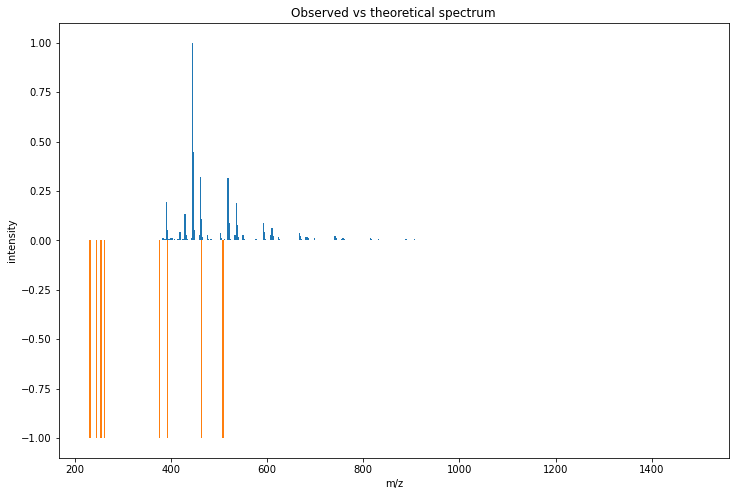

In [7]:
import numpy as np
from matplotlib import pyplot as plt

def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
  
    obs_int = [element / max(obs_int) for element in obs_int] 
    theo_int = [element * -1 for element in theo_int]
    plt.figure(figsize=(12,8))
    plt.bar(obs_mz, obs_int, width = 3.0)
    plt.bar(theo_mz, theo_int, width = 3.0)
    plt.title(title)
    plt.ylabel('intensity')
    plt.xlabel('m/z')

obs_mz, obs_int = observed_spectrum.get_peaks()

print(min(obs_mz)) 
print(max(obs_mz)) 

theo_mz, theo_int = [], []
for mz, intensity in zip(*theo_spectrum.get_peaks()):
    if mz >= 200.0 and mz <= 800.0:
        theo_mz.append(mz)
        theo_int.append(intensity)

title = 'Observed vs theoretical spectrum'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

## Now we want to find matching peaks between observed and theoretical spectrum. 

In [8]:
alignment = []
spa = SpectrumAlignment()
p = spa.getParameters()
p.setValue("tolerance", 0.5)
p.setValue("is_relative_tolerance", "false")
spa.setParameters(p)
spa.getSpectrumAlignment(alignment, theo_spectrum, observed_spectrum)

## The alignment contains a list of matched peak indices. We can simply inspect matching peaks with: 

In [9]:
print("Number of matched peaks: " + str(len(alignment)))
print("ion\ttheo. m/z\tobserved m/z")

for theo_idx, obs_idx in alignment:
    ion_name = theo_spectrum.getStringDataArrays()[0][theo_idx].decode()
    ion_charge = theo_spectrum.getIntegerDataArrays()[0][theo_idx]
    print(ion_name + "\t" + str(ion_charge) + "\t"
      + str(theo_spectrum[theo_idx].getMZ())
      + "\t" + str(observed_spectrum[obs_idx].getMZ()))

Number of matched peaks: 4
ion	theo. m/z	observed m/z
b3+	1	376.117299866671	376.22411236538517
y3+	1	393.191467089971	393.2828044891681
b4+	1	463.14932902617096	463.1491552628488
y4+	1	508.218411249471	507.91540959793383


## The mirror plot can also be used to visualize the aligned spectrum: 

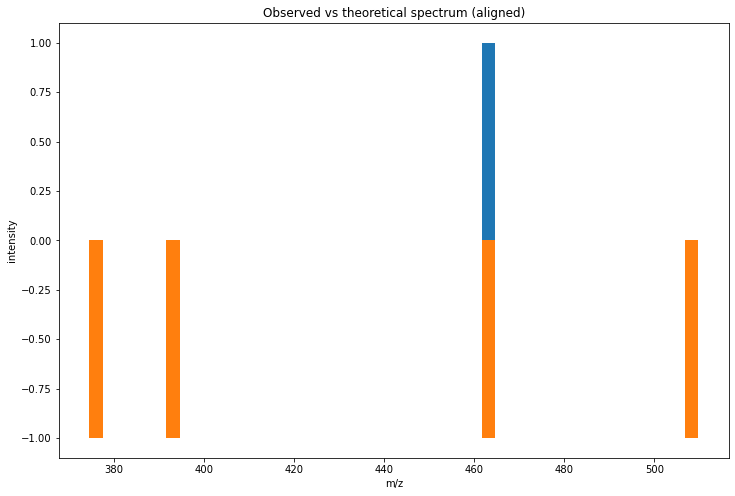

In [10]:
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for theo_idx, obs_idx in alignment:
    theo_mz.append(theo_spectrum[theo_idx].getMZ())
    theo_int.append(theo_spectrum[theo_idx].getIntensity())
    obs_mz.append(observed_spectrum[obs_idx].getMZ())
    obs_int.append(observed_spectrum[obs_idx].getIntensity())

title = 'Observed vs theoretical spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)